# Physics Informed Neural Network for Burgers problem

## Overview

Burgers' equation is a nonlinear partial differential equation that simulates the propagation and reflection of shock waves. It is widely used in the fields of fluid mechanics, nonlinear acoustics, gas dynamics et al. It is named after Johannes Martins Hamburg (1895-1981). In this case, MindFlow fluid simulation suite is used to solve the Burgers' equation in one-dimensional viscous state based on the physical-driven PINNs (Physics Informed Neural Networks) method.

## Problem Description

The form of Burgers' equation is as follows:

$$
u_t + uu_x = \epsilon u_{xx}, \quad x \in[-1,1], t \in[0, T],
$$

where $\epsilon=0.01/\pi$, the left of the equal sign is the convection term, and the right is the dissipation term. In this case, the Dirichlet boundary condition and the initial condition of the sine function are used. The format is as follows:

$$
u(t, -1) = u(t, 1) = 0,
$$

$$
u(0, x) = -sin(\pi x),
$$

In this case, the PINNs method is used to learn the mapping $(x, t) \mapsto u$ from position and time to corresponding physical quantities. So that the solution of Burgers' equation is realized.

In [1]:
import numpy as np

from mindspore.common import set_seed
from mindspore import context, nn
from mindspore.train import DynamicLossScaleManager
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import dtype as mstype

In [2]:
from mindflow.loss import Constraints
from mindflow.solver import Solver
from mindflow.common import LossAndTimeMonitor
from mindflow.cell import FCSequential
from mindflow.pde import Burgers1D
from mindflow.utils import load_yaml_config

set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
context.set_context(mode=context.GRAPH_MODE, save_graphs=False, device_target="GPU", device_id=6)

In [4]:
# load configurations
config = load_yaml_config('burgers_cfg.yaml')

## Training Dataset Construction

In this case, random sampling is performed according to the solution domain, initial condition and boundary value condition to generate training data sets. The specific settings are as follows:


In [5]:
from mindflow.data import Dataset
from mindflow.geometry import Interval, TimeDomain, GeometryWithTime
from mindflow.geometry import generate_sampling_config


def create_random_dataset(config):
    """create training dataset by online sampling"""
    geom_config = config["geometry"]
    data_config = config["data"]

    time_interval = TimeDomain("time", geom_config["time_min"], geom_config["time_max"])
    spatial_region = Interval("domain", geom_config["coord_min"], geom_config["coord_max"])
    region = GeometryWithTime(spatial_region, time_interval)
    region.set_sampling_config(generate_sampling_config(data_config))

    geom_dict = {region: ["domain", "IC", "BC"]}
    dataset = Dataset(geom_dict)

    return dataset

In [6]:
# create dataset
burgers_train_dataset = create_random_dataset(config)
train_dataset = burgers_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                     shuffle=True,
                                                     prebatched_data=True,
                                                     drop_remainder=True)

## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [7]:
# define models and optimizers
model = FCSequential(in_channels=config["model"]["in_channels"],
                     out_channels=config["model"]["out_channels"],
                     layers=config["model"]["layers"],
                     neurons=config["model"]["neurons"],
                     residual=config["model"]["residual"],
                     act=config["model"]["activation"])
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)
if context.get_context(attr_key='device_target') == "Ascend":
    model.to_float(mstype.float16)


## Optimizer

In [ ]:
# define optimizer
optimizer = nn.Adam(model.trainable_params(), config["optimizer"]["initial_lr"])

## Constraints

The `Constraints` class relates the PDE problems with the training datasets. `Burgers1D` contains the governing equations, boundary conditions, initial conditions et al. to solve the problem.

In [8]:
# define constraints
burgers_problems = [Burgers1D(model=model) for _ in range(burgers_train_dataset.num_dataset)]
train_constraints = Constraints(burgers_train_dataset, burgers_problems)


## Model Training

Invoke the `Solver` interface for model training and `callback` interface for evaluation.

In [9]:
# define solvers
solver = Solver(model,
                optimizer=optimizer,
                train_constraints=train_constraints,
                loss_scale_manager=DynamicLossScaleManager(),
                )

In [10]:
# define callbacks
callbacks = [LossAndTimeMonitor(len(burgers_train_dataset))]
if config["save_ckpt"]:
    config_ck = CheckpointConfig(save_checkpoint_steps=10, keep_checkpoint_max=2)
    ckpoint_cb = ModelCheckpoint(prefix='burgers_1d', directory=config["save_ckpt_path"], config=config_ck)
    callbacks += [ckpoint_cb]

In [13]:
# run the solver to train the model with callbacks
train_epochs = 1000
solver.train(train_epochs, train_dataset, callbacks=callbacks, dataset_sink_mode=True)

[WARNING] ME(94101:139845957165632,MainProcess):2022-11-08-08:21:20.170.877 [mindspore/train/model.py:1078] For LossAndTimeMonitor callback, {'epoch_begin', 'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 8, loss is 0.0060751243
epoch time: 1.116 s, per step time: 139.561 ms
epoch: 2 step: 8, loss is 0.013983292
epoch time: 0.240 s, per step time: 30.061 ms
epoch: 3 step: 8, loss is 0.0112056555
epoch time: 0.240 s, per step time: 30.061 ms
epoch: 4 step: 8, loss is 0.0068400386
epoch time: 0.239 s, per step time: 29.865 ms
epoch: 5 step: 8, loss is 0.002874342
epoch time: 0.239 s, per step time: 29.935 ms
epoch: 6 step: 8, loss is 0.0031645969
epoch time: 0.238 s, per step time: 29.787 ms
epoch: 7 step: 8, loss is 0.0011285502
epoch time: 0.238 s, per step time: 29.770 ms
epoch: 8 step: 8, loss is 0.0011632614
epoch time: 0.239 s, per step time: 29.861 ms
epoch: 9 step: 8, loss is 0.00090119574
epoch time: 0.239 s, per step time: 29.855 ms
epoch: 10 step: 8, loss is 0.0014845474
epoch time: 0.238 s, per step time: 29.693 ms
epoch: 11 step: 8, loss is 0.002550489
epoch time: 0.238 s, per step time: 29.734 ms
epoch: 12 step: 8, loss is 0.0021258325
epoch time: 0.240 s, per

## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized.

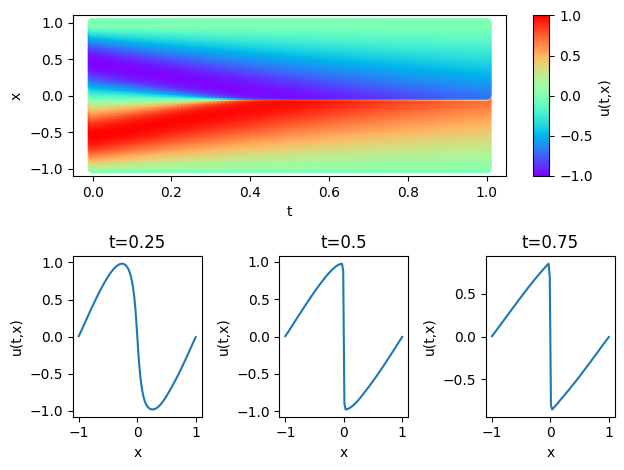

In [14]:
from src import visual_result

# visualization
visual_result(model, resolution=config["visual_resolution"])